# Analysing the calibration of the AudioProtoPNet model on BirdSet

In [1]:
# Load predictions from each test set by looping over all folders in /workspace/logs/predictions/convnext_bs and load the .pkl files

# load data in dict form: data[<dataset_name>] = (predictions, targets, metadata)
import os
import torch
from matplotlib import pyplot as plt
from uncertainbird.utils.misc import load_dump

data = {}

log_dir = "/workspace/logs/predictions/audioprotopnet"
dataset_names = sorted(
    [d for d in os.listdir(log_dir) if os.path.isdir(os.path.join(log_dir, d))]
)

# colormap without red (tab10 index 3 is red)
colors = plt.cm.tab10
skip_index = 3
available_indices = [i for i in range(colors.N) if i != skip_index]
dataset_colors = {}

for i, ds in enumerate(dataset_names):
    data[ds] = {}
    color_idx = available_indices[i % len(available_indices)]
    dataset_colors[ds] = colors(color_idx)

    ds_path = os.path.join(log_dir, ds)
    pkl_files = [f for f in os.listdir(ds_path) if f.endswith(".pkl")]
    if not pkl_files:
        continue
    # pick most recent file
    pkl_files.sort(
        key=lambda f: os.path.getmtime(os.path.join(ds_path, f)), reverse=True
    )
    file_path = os.path.join(ds_path, pkl_files[0])
    preds, t, metadata = load_dump(file_path)
    data[ds]["predictions"] = preds
    data[ds]["targets"] = t.int()
    data[ds]["metadata"] = metadata
    data[ds]["color"] = dataset_colors[ds]

# concatenate
valid_keys = [
    k
    for k, v in data.items()
    if isinstance(v, dict)
    and "predictions" in v
    and "targets" in v
    and isinstance(v["predictions"], torch.Tensor)
    and isinstance(v["targets"], torch.Tensor)
]

if not valid_keys:
    raise ValueError("No datasets with both 'predictions' and 'targets' present.")

# optionally report skipped datasets
skipped = [k for k in data.keys() if k not in valid_keys]
if skipped:
    print("Skipped datasets (missing predictions/targets):", skipped)

predictions = torch.cat([data[k]["predictions"] for k in valid_keys], dim=0)
targets = torch.cat([data[k]["targets"] for k in valid_keys], dim=0)

data = {k: data[k] for k in valid_keys}

predictions.shape, targets.shape

/workspace/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/workspace/.venv/lib/python3.10/site-packages/torch_audiomentations/utils/io.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


Loaded data with 12000 samples
Predictions shape: torch.Size([12000, 9736])
Targets shape: torch.Size([12000, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 539 samples
Predictions shape: torch.Size([539, 9736])
Targets shape: torch.Size([539, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 24480 samples
Predictions shape: torch.Size([24480, 9736])
Targets shape: torch.Size([24480, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 15120 samples
Predictions shape: torch.Size([15120, 9736])
Targets shape: torch.Size([15120, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 4560 samples
Predictions shape: torch.Size([4560, 9736])
Targets shape: torch.Size([4560, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilab

(torch.Size([117092, 9736]), torch.Size([117092, 9736]))

In [2]:
data["HSN"].keys()

dict_keys(['predictions', 'targets', 'metadata', 'color'])

## Global - all labels incl. non present target labels

In [3]:
from uncertainbird.utils.plotting import print_metrics

metrics = print_metrics(predictions, targets)

/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028
/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Accuracy: tensor(0.9999)
cmAP: tensor(0.3016)
Precision: tensor(0.0180)
Recall: tensor(0.0058)
F1 Score: tensor(0.0070)
AUROC: tensor(0.0366)
ECE: tensor(0.1069)
ECE Weighted: tensor(0.1266)
ECE Top-3: tensor(0.1232)
ECE Top-5: tensor(0.1245)
ECE Top-10: tensor(0.1193)
ECE Top-21: tensor(0.1244)


<Axes: title={'center': 'Reliability Diagram - ConvNeXt_BS on BirdSet | ECE weighted = 12.66%'}, xlabel='Mean Predicted Probability', ylabel='Fraction of Positives'>

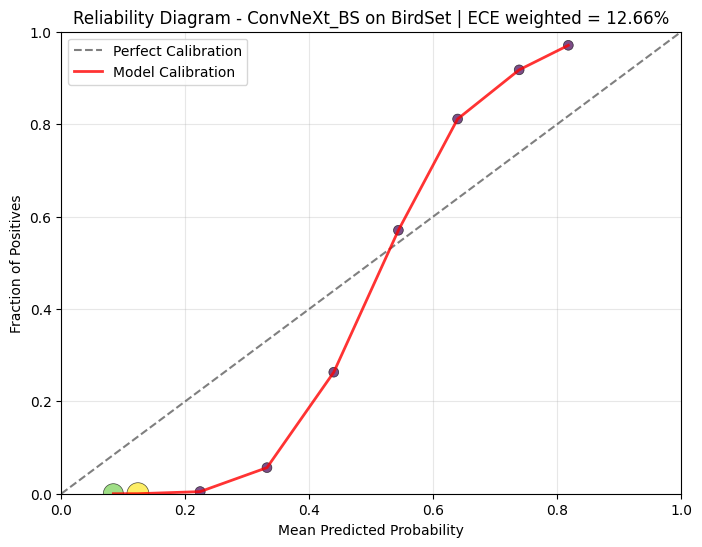

In [4]:
# reliability diagram
from uncertainbird.utils.plotting import plot_reliability_diagram

plot_reliability_diagram(
    predictions,
    targets,
    n_bins=10,
    title=f"Reliability Diagram - ConvNeXt_BS on BirdSet | ECE weighted = {metrics['ece_weighted']*100:.2f}%",
)

## Globael - only classes present in the target labels

```python

In [5]:
# how many classes are represented by atleast one sample in the targets?
print("Number of classes in targets:", targets.sum(dim=0).gt(0).sum().item())
# how many classes are represented by atleast 5 samples in the targets?
print(
    "Number of classes with atleast 5 samples in targets:",
    targets.sum(dim=0).ge(5).sum().item(),
)

Number of classes in targets: 383
Number of classes with atleast 5 samples in targets: 334


In [6]:
# select only target classes
predictions_targetclasses = predictions[:, targets.sum(dim=0).gt(0)]
targets_targetclasses = targets[:, targets.sum(dim=0).gt(0)]

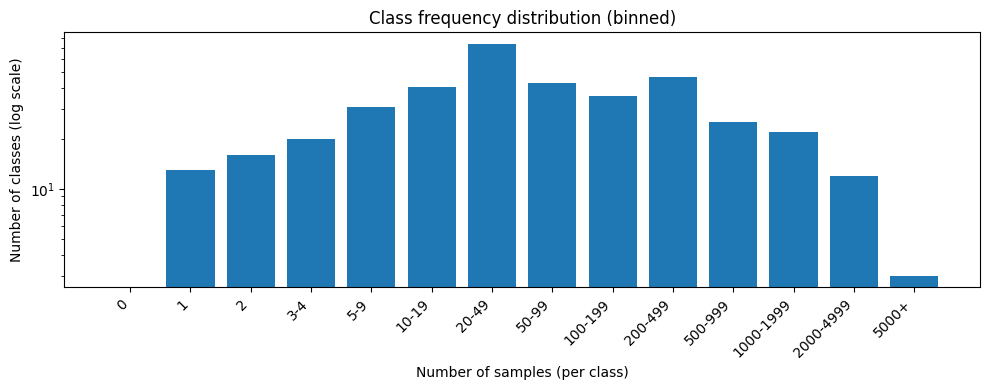

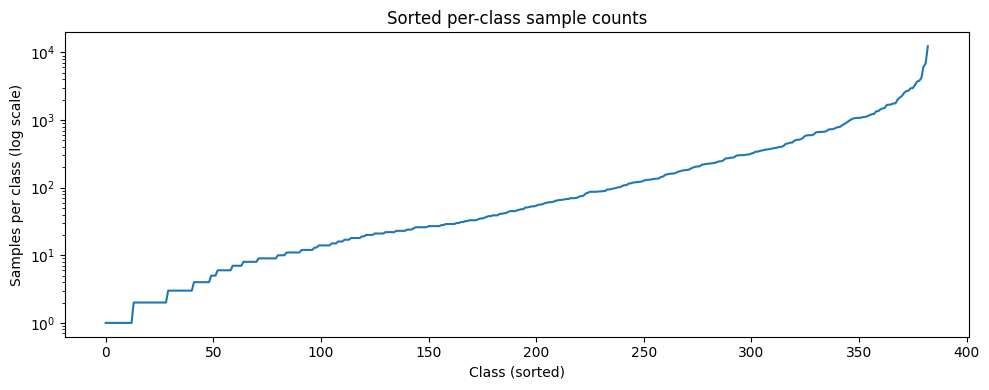

In [7]:
from uncertainbird.utils.plotting import plot_class_frequency

plot_class_frequency(targets_targetclasses)

In [8]:
from uncertainbird.utils.plotting import print_metrics

metrics_targetclasses = print_metrics(predictions_targetclasses, targets_targetclasses)

Accuracy: tensor(0.9973)
cmAP: tensor(0.3016)
Precision: tensor(0.4564)
Recall: tensor(0.1476)
F1 Score: tensor(0.1771)
AUROC: tensor(0.9317)
ECE: tensor(0.1381)
ECE Weighted: tensor(0.1266)
ECE Top-3: tensor(0.1232)
ECE Top-5: tensor(0.1245)
ECE Top-10: tensor(0.1193)
ECE Top-21: tensor(0.1244)


<Axes: title={'center': 'Reliability Diagram - ConvNeXt_BS on BirdSet`s target classes | ECE weighted = 12.66%'}, xlabel='Mean Predicted Probability', ylabel='Fraction of Positives'>

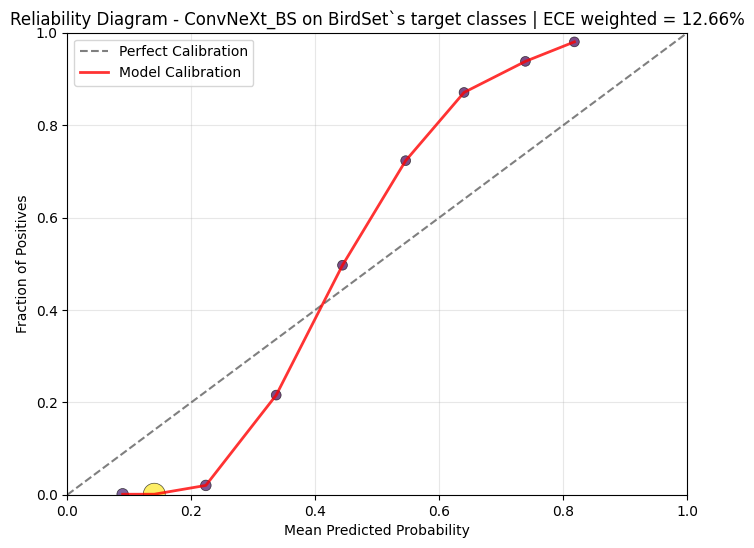

In [9]:
# reliability diagram
from uncertainbird.utils.plotting import plot_reliability_diagram

plot_reliability_diagram(
    predictions_targetclasses,
    targets_targetclasses,
    n_bins=10,
    title=f"Reliability Diagram - ConvNeXt_BS on BirdSet`s target classes | ECE weighted = {metrics_targetclasses['ece_weighted']*100:.2f}%",
)

## Class-wise Calibration Plots

In [10]:
# only select classes with target labels
for key in list(data.keys()):
    # keep the dict structure; only replace the predictions/targets tensors
    preds = data[key]["predictions"][:, targets.sum(dim=0).gt(0)]
    tars = data[key]["targets"][:, targets.sum(dim=0).gt(0)]
    data[key]["predictions"] = preds
    data[key]["targets"] = tars
    # metadata and color remain unchanged

In [11]:
# compute metrics
for key in data:
    print("Computing metrics for", key)
    preds = data[key]["predictions"]
    tar = data[key]["targets"]
    data[key]["metrics"] = print_metrics(preds, tar)

Computing metrics for HSN


/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028
/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Accuracy: tensor(0.9988)
cmAP: tensor(0.5536)
Precision: tensor(0.0306)
Recall: tensor(0.0093)
F1 Score: tensor(0.0130)
AUROC: tensor(0.0509)
ECE: tensor(0.1210)
ECE Weighted: tensor(0.1036)
ECE Top-3: tensor(0.0984)
ECE Top-5: tensor(0.0971)
ECE Top-10: tensor(0.1124)
ECE Top-21: tensor(0.1211)
Computing metrics for NBP
Accuracy: tensor(0.9965)
cmAP: tensor(0.6556)
Precision: tensor(0.1031)
Recall: tensor(0.0325)
F1 Score: tensor(0.0448)
AUROC: tensor(0.1228)
ECE: tensor(0.1341)
ECE Weighted: tensor(0.1617)
ECE Top-3: tensor(0.1650)
ECE Top-5: tensor(0.1696)
ECE Top-10: tensor(0.1658)
ECE Top-21: tensor(0.1591)
Computing metrics for NES
Accuracy: tensor(0.9988)
cmAP: tensor(0.3781)
Precision: tensor(0.1013)
Recall: tensor(0.0510)
F1 Score: tensor(0.0596)
AUROC: tensor(0.2198)
ECE: tensor(0.1427)
ECE Weighted: tensor(0.1301)
ECE Top-3: tensor(0.1240)
ECE Top-5: tensor(0.1327)
ECE Top-10: tensor(0.1284)
ECE Top-21: tensor(0.1322)
Computing metrics for PER
Accuracy: tensor(0.9940)
cmAP: 

### Reliability Diagram
```

#### Combined

<Axes: title={'center': 'Combined Reliability Diagram - ConvNeXt_BS on BirdSet'}, xlabel='Mean Predicted Probability', ylabel='Fraction of Positives'>

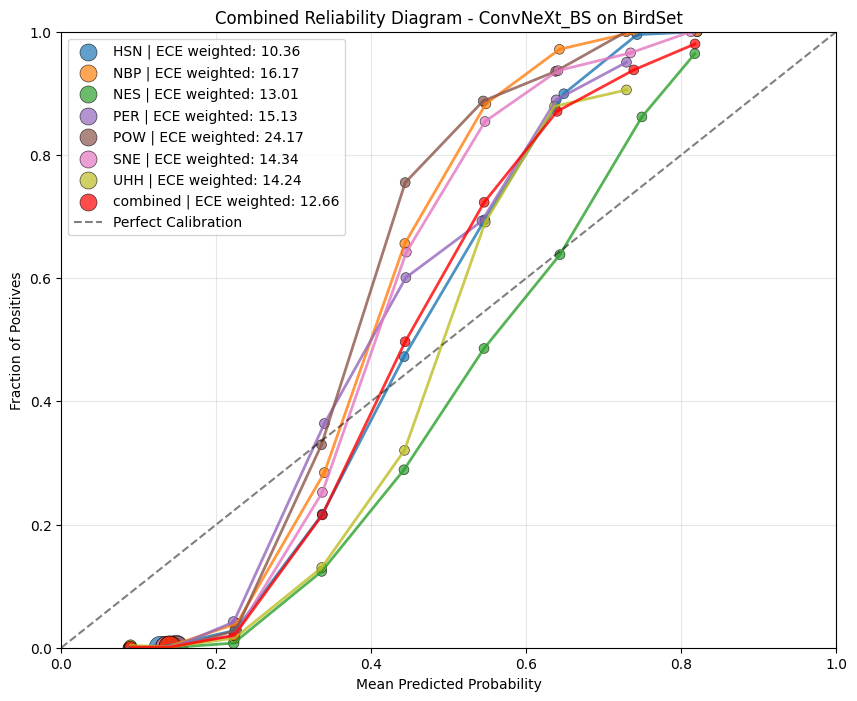

In [12]:
from uncertainbird.utils.plotting import plot_combined_reliability_diagram

# add average / combined data of all datasets
data["combined"] = {
    "predictions": predictions_targetclasses,
    "targets": targets_targetclasses,
    "metadata": None,
    "metrics": metrics_targetclasses,
    "color": "red",  # color for combined plot
}

plot_combined_reliability_diagram(
    data, n_bins=10, title="Combined Reliability Diagram - ConvNeXt_BS on BirdSet"
)

#### Per class

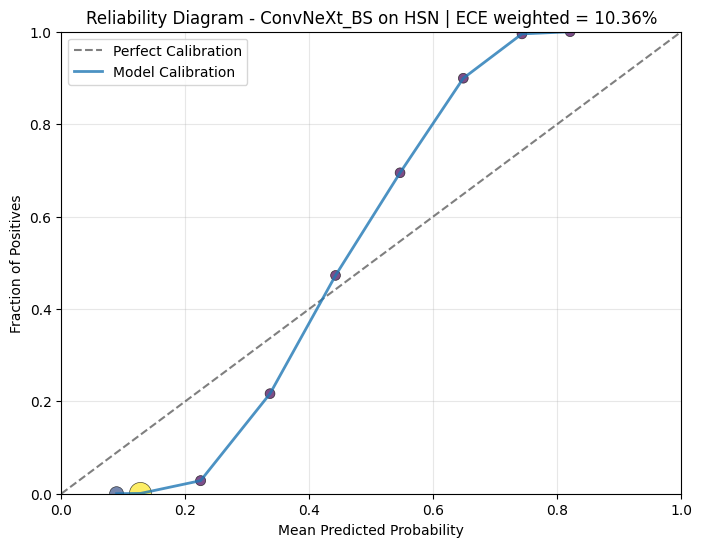

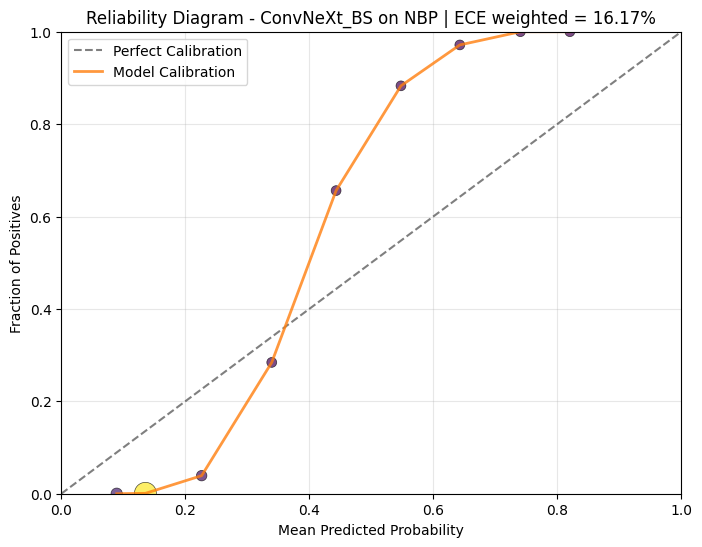

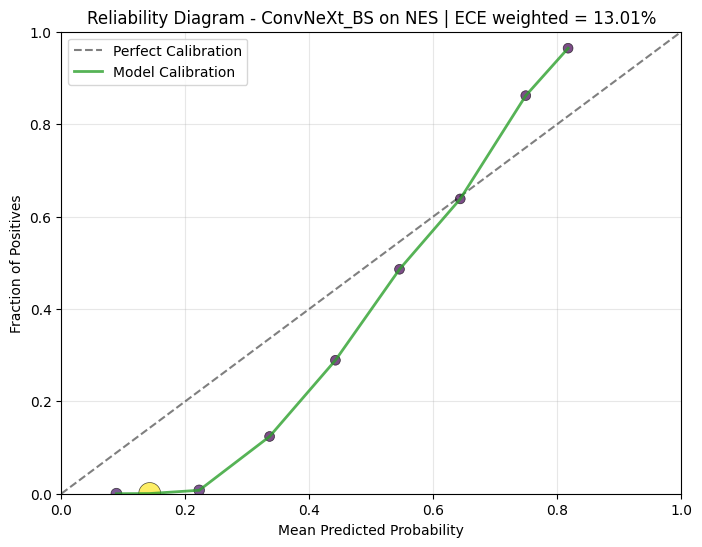

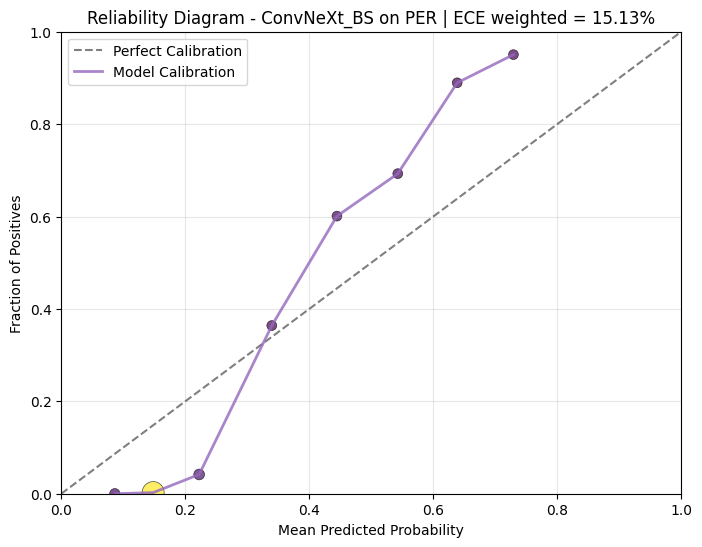

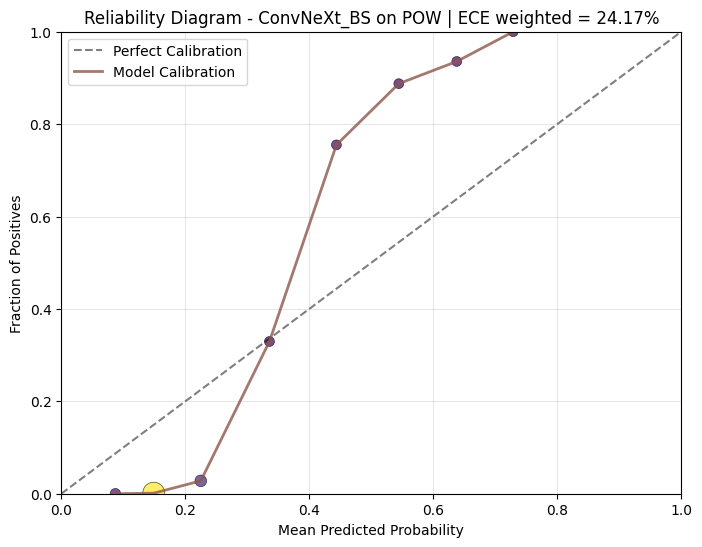

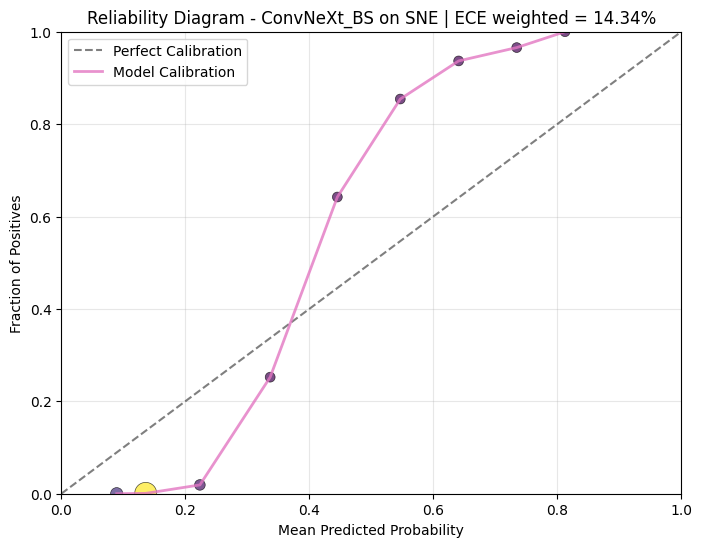

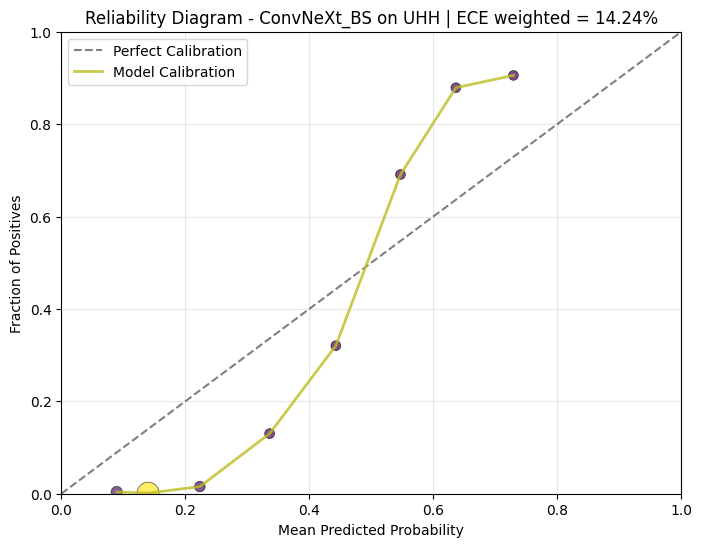

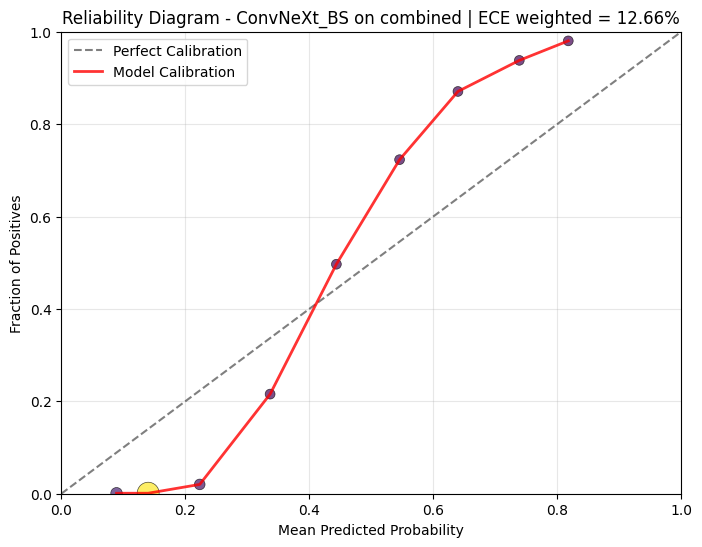

In [13]:
for key in data:
    plot_reliability_diagram(
        data[key]["predictions"],
        data[key]["targets"],
        n_bins=10,
        title=f"Reliability Diagram - ConvNeXt_BS on {key} | ECE weighted = {data[key]['metrics']['ece_weighted']*100:.2f}%",
        color=data[key].get("color", "red"),
    )

In [14]:
from uncertainbird.utils.misc import class_wise_statistics

preds = predictions_targetclasses.float()
tar = targets_targetclasses.int()

class_stats = class_wise_statistics(preds, tar, n_bins=10)

/workspace/.venv/lib/python3.10/site-packages/torchmetrics/functional/classification/calibration_error.py:48: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /pytorch/aten/src/ATen/native/BucketizationUtils.h:32.)
  indices = torch.bucketize(confidences, bin_boundaries, right=True) - 1


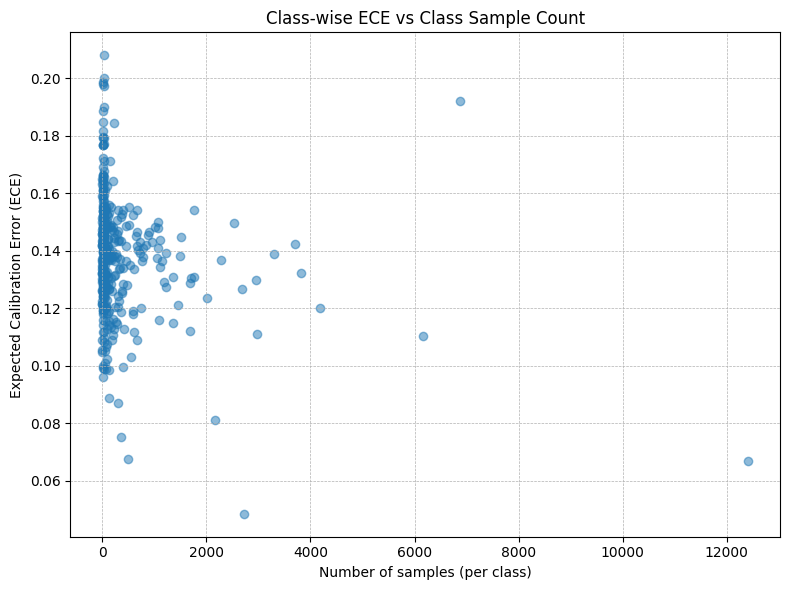

In [18]:
# plot ece vs class sample count
plt.figure(figsize=(8, 6))
plt.scatter(class_stats["positive_samples"], class_stats["ece"], alpha=0.5)
plt.xlabel("Number of samples (per class)")
plt.ylabel("Expected Calibration Error (ECE)")
plt.title("Class-wise ECE vs Class Sample Count")
plt.grid(True, ls="--", lw=0.5)
plt.tight_layout()
plt.show()

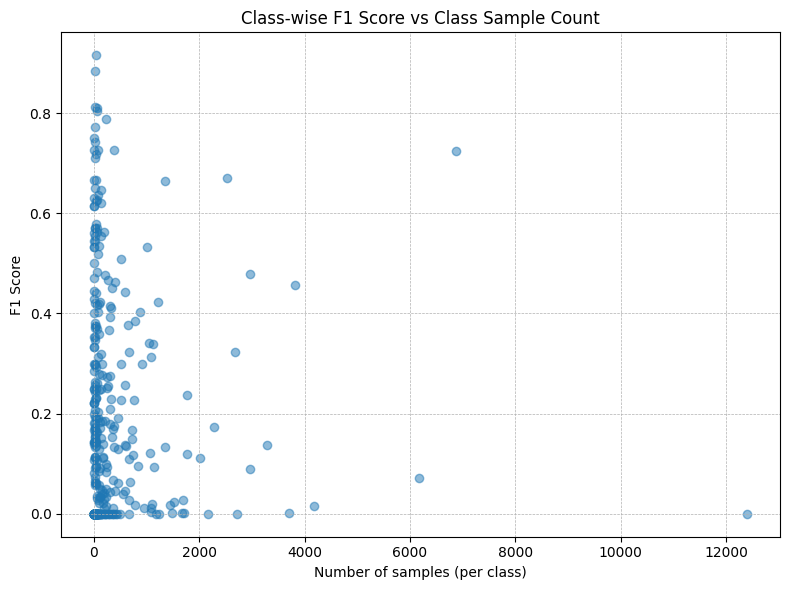

In [16]:
# f1 vs class sample count
plt.figure(figsize=(8, 6))
plt.scatter(class_stats["positive_samples"], class_stats["f1_score"], alpha=0.5)
plt.xlabel("Number of samples (per class)")
plt.ylabel("F1 Score")
plt.title("Class-wise F1 Score vs Class Sample Count")
plt.grid(True, ls="--", lw=0.5)
plt.tight_layout()

In [20]:
# print cmAP for each dataset in the format "Dataset: <name>, cmAP: <value>"
for key in data:
    print(f"Dataset: {key}, ece: {data[key]['metrics']['ece_weighted']*100:.2f}")

Dataset: HSN, ece: 10.36
Dataset: NBP, ece: 16.17
Dataset: NES, ece: 13.01
Dataset: PER, ece: 15.13
Dataset: POW, ece: 24.17
Dataset: SNE, ece: 14.34
Dataset: UHH, ece: 14.24
Dataset: combined, ece: 12.66
